In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True,
                     "font.size": 14,
                     "pdf.fonttype": 42,
                     "ps.fonttype": 42})

In [2]:
def filterByScenario (df_op):
  scenario_list=["ns_clear", "scp_ckpt", "create_ns", "clear_arp"]
  filtered_df=pd.DataFrame()
  #filtered_df["iter"]=df_op["iter"].unique()
  for scenario in scenario_list:
    filtered_df[scenario] = df_op[df_op["scenario"] == scenario].reset_index()["elapsed"]
  return filtered_df

In [4]:
PATH = "../log/iperf_triple_ctl_s2c/"
iperf_df = pd.read_csv(PATH + "iperf.csv", sep=',')
iperf_state_df = pd.read_csv(PATH + "container_state.csv", sep=',')
iperf_op_df = pd.read_csv(PATH + "iperf_op_time.csv", sep=',')
iperf_op_df=filterByScenario(iperf_op_df)
iperf_dump_df = pd.read_csv(PATH + "podman_dump.csv", sep=',')
iperf_restore_df = pd.read_csv(PATH + "podman_restore.csv", sep=',')

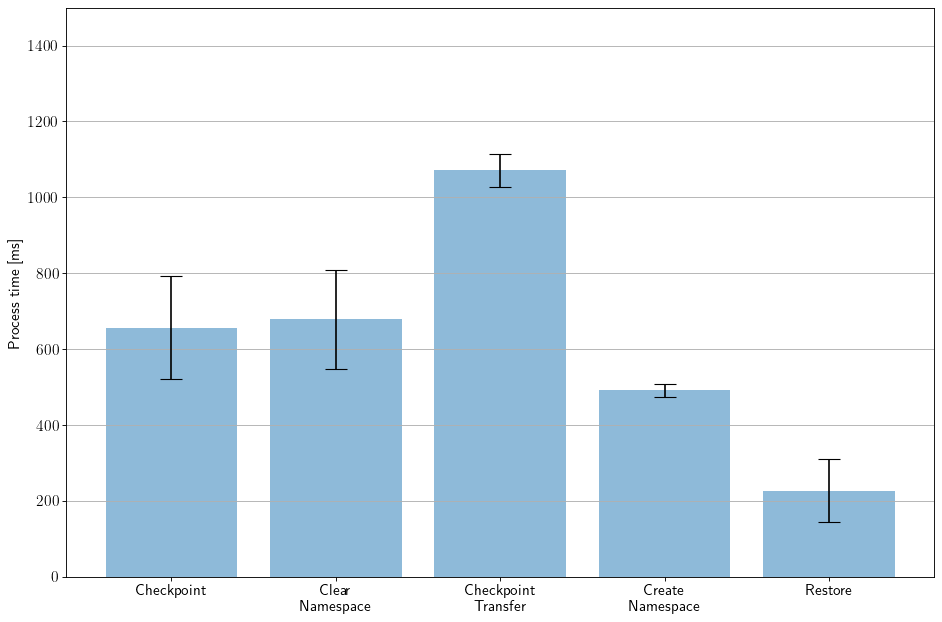

In [5]:
df = pd.DataFrame()

df[["ns_clear","scp_ckpt","create_ns"]] = iperf_op_df[["ns_clear","scp_ckpt","create_ns"]]*1000
df
df["checkpoint"] = iperf_dump_df[["podman_checkpoint_duration"]]/1000
df[["restore"]] = iperf_restore_df[["podman_restore_duration"]]/1000

drop_index = []

for i in range(len(df)):
    if(df.iloc[i]["ns_clear"]>2000):
        drop_index.append(i)
df.drop(drop_index, axis=0, inplace=True)

df_plot = df[["checkpoint","ns_clear","scp_ckpt","create_ns","restore"]]
mean_data = df_plot.mean().values
std = df_plot.std().values
x_label = ["Checkpoint","Clear\nNamespace","Checkpoint\nTransfer","Create\nNamespace","Restore"]
x_pos = np.arange(len(x_label))

fig, ax = plt.subplots(figsize=(12, 8), dpi=80)
ax.bar(x_pos,mean_data , yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Process time [ms]')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label)
ax.yaxis.grid(True)
ax.set_ylim([0,1500])
plt.tight_layout()
plt.show()

In [6]:
iperf_df.head()

,iter,socket,mss,start,end,bps
0,1,6,1000,0.000000,0.100078,1.020401e+08
1,1,6,1000,0.100078,0.200083,9.579169e+07
2,1,6,1000,0.200083,0.300091,9.721142e+07
3,1,6,1000,0.300091,0.400076,9.620611e+07
4,1,6,1000,0.400076,0.500071,9.682884e+07


In [7]:
thr_df = iperf_df[["iter","socket"]]
thr_df["bps"] = iperf_df["bps"]/(1e6)

thr_df

/tmp/ipykernel_635128/1314506074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thr_df["bps"] = iperf_df["bps"]/(1e6)


,iter,socket,bps
0,1,6,102.040087
1,1,6,95.791690
2,1,6,97.211420
3,1,6,96.206108
4,1,6,96.828839
...,...,...,...
9995,50,6,473.677255
9996,50,6,491.266670
9997,50,6,492.829937
9998,50,6,475.083064


In [80]:
thr_groups = thr_df.groupby("iter")

<Figure size 640x480 with 0 Axes>

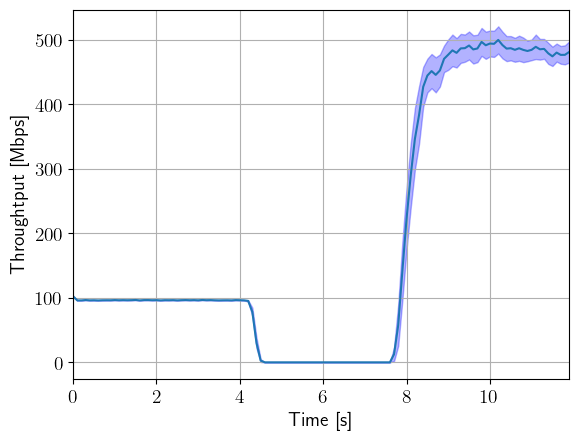

In [9]:
thr_groups = thr_df.groupby("iter")

plt.figure()


avg = []
std = []
ci = [] # 90% CI
data= []
for i in range(50):
    group = thr_groups.get_group(i+1)
    value = group["bps"].values
    data.append(value[0:120])
data_array = np.array(data,np.float32)
for i in range(120):
    avg.append(data_array[:,i].mean())
    std.append(data_array[:,i].std())
    ci.append(1.645 *data_array[:,i].std()/np.sqrt(len(data_array[:,i])))


# print(ci)
x_real = np.arange(0,120,1)/10
fig, ax = plt.subplots()
ax.plot(x_real,avg)
ax.fill_between(x_real, (np.array(avg)-np.array(ci)), (np.array(avg)+np.array(ci)), color='b', alpha=.3)
# ax.set_yscale("log")
ax.set_ylabel("Throughtput [Mbps]")
ax.set_xlabel("Time [s]")
ax.grid()
ax.autoscale(enable=True, axis='x', tight=True)
fig.savefig("../figures/throughput.pdf",format="pdf")

In [82]:
PATH = "./log/"
iperf_down_df = pd.read_csv(PATH + "iperf_triple_ctl_s2c/iperf.csv", sep=',')
iperf_up_df =pd.read_csv(PATH + "iperf_c2s_only/iperf.csv", sep=',')

In [83]:
interrupt_down=[]
interrupt_up = []
for i in range(50):
    interrupt_down.append((iperf_down_df.loc[(iperf_down_df['iter']==i+1) & (iperf_down_df['bps']==0)]['bps'].count())/10)
    interrupt_up.append((iperf_up_df.loc[(iperf_up_df['iter']==i+1) & (iperf_up_df['bps']==0)]['bps'].count())/10)
interrupt_down=np.array(interrupt_down)
interrupt_up =np.array(interrupt_up)
avg_down = interrupt_down.mean()
std_down = interrupt_down.std()
avg_up = interrupt_up.mean()
std_up = interrupt_up.std()


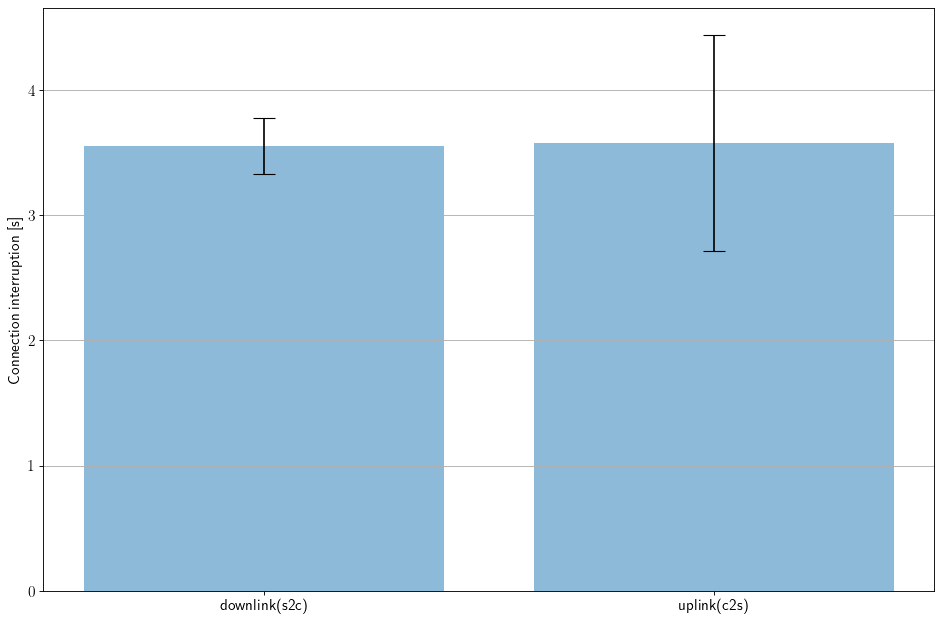

In [84]:
x_axis = ["downlink(s2c)","uplink(c2s)"]
x_pos = np.arange(len(x_axis))

fig, ax = plt.subplots(figsize=(12, 8), dpi=80)
ax.bar(x_pos,[avg_down,avg_up] , yerr=[std_down,std_up], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Connection interruption [s]')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_axis)
ax.yaxis.grid(True)
# ax.set_yscale("log")
# Save the figure and show
plt.tight_layout()
plt.show()

In [85]:
latency=[]
raw_sockperf_non_arp_latency_df = pd.read_csv(PATH + "sockperf_non_arp/pruned_sockperf.csv", sep=',')
latency_groups = raw_sockperf_non_arp_latency_df.groupby(['iter'])

for i in range(50):
    latency_group = latency_groups.get_group(i+1)
    max_latency = latency_group["latency"].max()*2/1000000
    if (max_latency>1):
        latency.append(max_latency)
latency = np.array(latency)
avg_latency =  latency.mean()
std_latency = latency.std()


x_axis = ["iperf_s2c","iperf_c2s","sockperf"]
x_pos = np.arange(len(x_axis))

fig, ax = plt.subplots(figsize=(12, 8), dpi=80)
ax.bar(x_pos,[avg_down,avg_up,avg_latency] , yerr=[std_down,std_up,std_latency], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Connection Disruption Duration [s]')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_axis)
ax.yaxis.grid(True)
# ax.set_yscale("log")
# Save the figure and show
plt.tight_layout()
plt.show()


RuntimeError: latex was not able to process the following string:
b'iperf_s2c'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/rex/.cache/matplotlib/tex.cache/6184d226c602eb7d4d3281262b914253.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./6184d226c602eb7d4d3281262b914253.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{14.000000}{17.500000}{\sffamily iperf_
                                                  s2c}
No pages of output.
Transcript written on 6184d226c602eb7d4d3281262b914253.log.




RuntimeError: latex was not able to process the following string:
b'iperf_s2c'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/rex/.cache/matplotlib/tex.cache/6184d226c602eb7d4d3281262b914253.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./6184d226c602eb7d4d3281262b914253.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{14.000000}{17.500000}{\sffamily iperf_
                                                  s2c}
No pages of output.
Transcript written on 6184d226c602eb7d4d3281262b914253.log.




<Figure size 960x640 with 1 Axes>